# Data augmentation

## Overview

Data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

You will learn how to apply data augmentation in two ways:

- Use the Keras preprocessing layers, such as `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip`, and `tf.keras.layers.RandomRotation`.
- Use the `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Download a dataset


In [60]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'Beans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes.

In [61]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

3


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

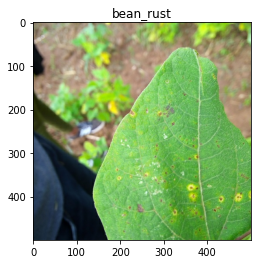

In [62]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

### Resizing and rescaling


You can use the Keras preprocessing layers to resize your images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [63]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.


You can visualize the result of applying these layers to an image. 

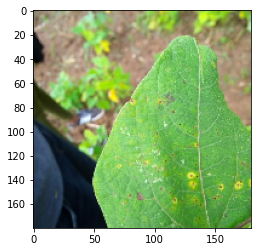

In [64]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Verify that the pixels are in the `[0, 1]` range:

In [65]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as `tf.keras.layers.RandomFlip` and `tf.keras.layers.RandomRotation`.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [66]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [67]:
# Add the image to a batch.
image = tf.expand_dims(image, 0)

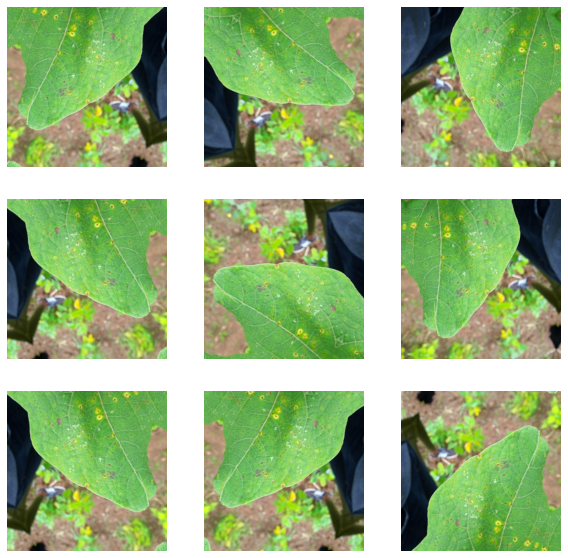

In [68]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers you can use for data augmentation including `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom`, and others.

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model

In [69]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` (not `Model.evaluate` or `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [70]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. 

Note: Data augmentation should only be applied to the training set.

In [71]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [72]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, we will now train a model using the datasets we have just prepared.

The Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). 

In [73]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train for a few epochs:

In [75]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 6s 133ms/step - loss: 1.2031 - accuracy: 0.3833 - val_loss: 1.0726 - val_accuracy: 0.4231
Epoch 2/10
26/26 [==============================] - 4s 118ms/step - loss: 1.0063 - accuracy: 0.4946 - val_loss: 0.8408 - val_accuracy: 0.7308
Epoch 3/10
26/26 [==============================] - 4s 121ms/step - loss: 0.8843 - accuracy: 0.6143 - val_loss: 0.8273 - val_accuracy: 0.6538
Epoch 4/10
26/26 [==============================] - 4s 119ms/step - loss: 0.8573 - accuracy: 0.6227 - val_loss: 0.7484 - val_accuracy: 0.6923
Epoch 5/10
26/26 [==============================] - 4s 118ms/step - loss: 0.7562 - accuracy: 0.6687 - val_loss: 0.7672 - val_accuracy: 0.6731
Epoch 6/10
26/26 [==============================] - 3s 113ms/step - loss: 0.7600 - accuracy: 0.6808 - val_loss: 0.6641 - val_accuracy: 0.6827
Epoch 7/10
26/26 [==============================] - 3s 114ms/step - loss: 0.7217 - accuracy: 0.6856 - val_loss: 0.6403 - val_accuracy: 0.7308
Epoch 

In [76]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

4/4 [==============================] - 0s 58ms/step - loss: 0.7752 - accuracy: 0.6796
Accuracy 0.6796116232872009


### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a `tf.keras.layers.Lambda` layer. This is a good way to write concise code.
- Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control.

Both layers will randomly invert the colors in an image, according to some probability.

In [77]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [78]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

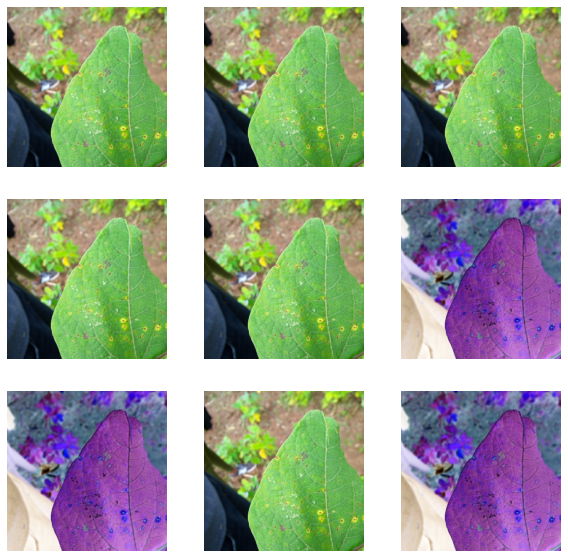

In [79]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [80]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

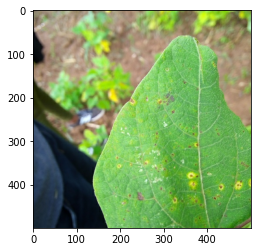

In [81]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above Keras preprocessing utilities are convenient. But, for finer control, we can write our own data augmentation pipelines or layers using `tf.data` and `tf.image`.

Since the beans dataset was previously configured with data augmentation, let's reimport it to start fresh:

In [82]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'Beans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with:

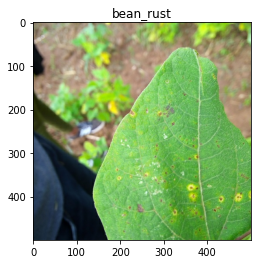

In [84]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side:

In [85]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

#### Flip an image

Flip an image either vertically or horizontally with `tf.image.flip_left_right`:

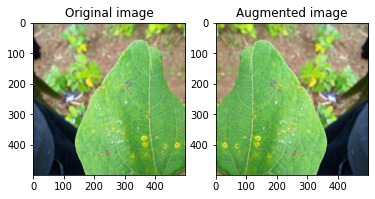

In [86]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale an image

You can grayscale an image with `tf.image.rgb_to_grayscale`:

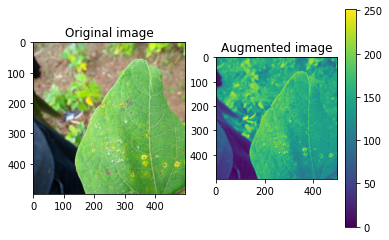

In [87]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate an image

Saturate an image with `tf.image.adjust_saturation` by providing a saturation factor:

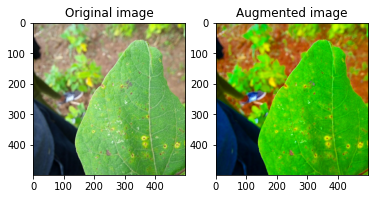

In [88]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness

Change the brightness of image with `tf.image.adjust_brightness` by providing a brightness factor:

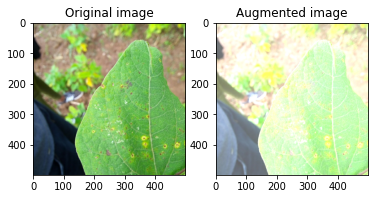

In [89]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop an image

Crop the image from center up to the image part you desire using `tf.image.central_crop`:

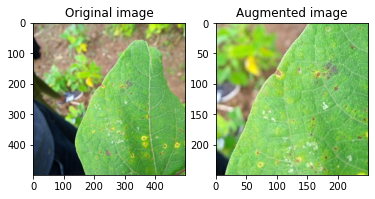

In [90]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### Rotate an image

Rotate an image by 90 degrees with `tf.image.rot90`:

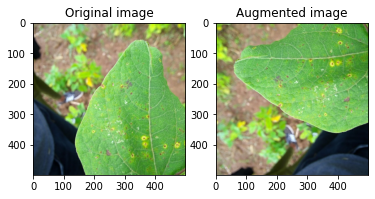

In [91]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Random transformations

#### Randomly change image brightness

Randomly change the brightness of `image` using `tf.image.stateless_random_brightness` by providing a brightness factor and `seed`. The brightness factor is chosen randomly in the range `[-max_delta, max_delta)` and is associated with the given `seed`.

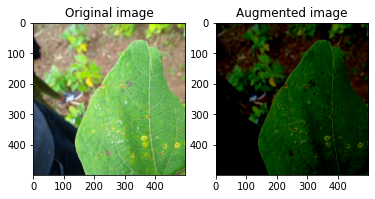

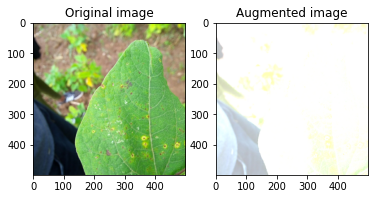

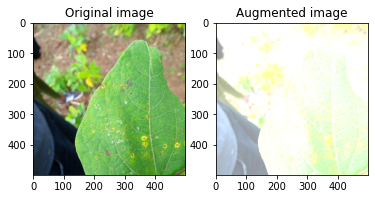

In [92]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### Randomly change image contrast

Randomly change the contrast of `image` using `tf.image.stateless_random_contrast` by providing a contrast range and `seed`. The contrast range is chosen randomly in the interval `[lower, upper]` and is associated with the given `seed`.

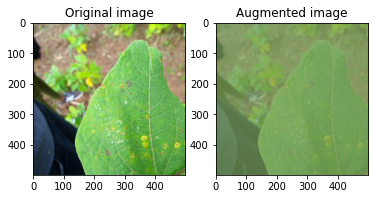

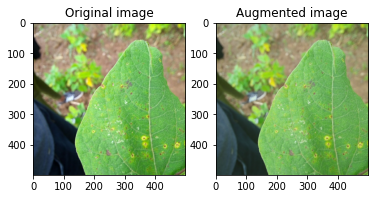

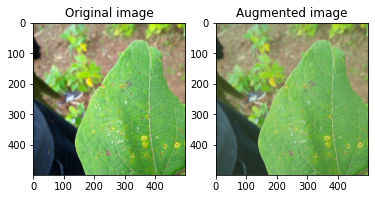

In [93]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### Randomly crop an image

Randomly crop `image` using `tf.image.stateless_random_crop` by providing target `size` and `seed`. The portion that gets cropped out of `image` is at a randomly chosen offset and is associated with the given `seed`.

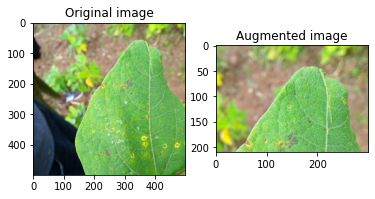

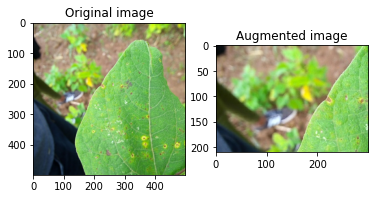

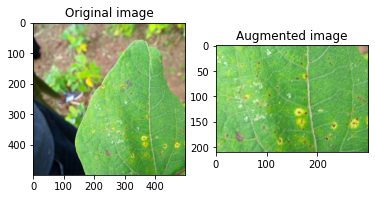

In [94]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

Let's first download the image dataset again in case they are modified in the previous sections.

In [95]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'Beans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Next, define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:

In [96]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define the `augment` function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [97]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Option 1: Using tf.data.experimental.Counter

Create a `tf.data.experimental.Counter` object (let's call it `counter`) and `Dataset.zip` the dataset with `(counter, counter)`. This will ensure that each image in the dataset gets associated with a unique value (of shape `(2,)`) based on `counter` which later can get passed into the `augment` function as the `seed` value for random transformations.

In [98]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Map the `augment` function to the training dataset:

In [99]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [100]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [101]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

In [102]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [103]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 5s 97ms/step - loss: 1.2687 - accuracy: 0.3628 - val_loss: 1.0973 - val_accuracy: 0.4712
Epoch 2/10
26/26 [==============================] - 2s 79ms/step - loss: 1.0709 - accuracy: 0.4039 - val_loss: 1.0525 - val_accuracy: 0.5192
Epoch 3/10
26/26 [==============================] - 2s 80ms/step - loss: 0.9603 - accuracy: 0.5357 - val_loss: 0.9664 - val_accuracy: 0.5385
Epoch 4/10
26/26 [==============================] - 2s 79ms/step - loss: 0.8460 - accuracy: 0.6167 - val_loss: 0.7142 - val_accuracy: 0.6635
Epoch 5/10
26/26 [==============================] - 2s 80ms/step - loss: 0.7197 - accuracy: 0.6808 - val_loss: 0.8347 - val_accuracy: 0.6250
Epoch 6/10
26/26 [==============================] - 2s 87ms/step - loss: 0.6707 - accuracy: 0.7050 - val_loss: 0.7486 - val_accuracy: 0.6346
Epoch 7/10
26/26 [==============================] - 2s 80ms/step - loss: 0.5345 - accuracy: 0.7690 - val_loss: 0.7076 - val_accuracy: 0.6827
Epoch 8/10
26

In [105]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

4/4 [==============================] - 1s 87ms/step - loss: 0.8417 - accuracy: 0.6990
Accuracy 0.6990291476249695
